# Understanding RAG (Retrieval-Augmented Generation)

## Learning Objectives
By the end of this notebook, you will understand:
1. What RAG is and why it's important
2. The components of a RAG system
3. How retrieval and generation work together
4. Common challenges and solutions

## What is RAG?

RAG stands for **Retrieval-Augmented Generation**. It's a technique that combines:
- **Retrieval**: Finding relevant information from a knowledge base
- **Augmented**: Enhancing the LLM's input with retrieved information
- **Generation**: Using an LLM to generate responses based on the augmented input

### Why do we need RAG?

1. **Knowledge Cutoff**: LLMs have training data cutoffs and don't know recent information
2. **Hallucination**: LLMs can make up facts that sound plausible
3. **Domain Specificity**: General LLMs may not be experts in specific domains
4. **Cost Efficiency**: Retrieving relevant context reduces the need for larger models

## RAG Architecture Components

```
Query → Retriever → Retrieved Docs → Generator → Response
                    ↑                        ↑
                Knowledge Base            LLM
```

### 1. Knowledge Base
- **Documents**: Raw text data (Wikipedia, PDFs, etc.)
- **Chunks**: Split documents into manageable pieces
- **Embeddings**: Vector representations of chunks
- **Vector Store**: Database for similarity search

### 2. Retriever
- **Embedding Model**: Converts text to vectors
- **Similarity Search**: Finds relevant chunks
- **Ranking**: Orders results by relevance

### 3. Generator
- **LLM**: Large Language Model (Llama, GPT, etc.)
- **Prompt Engineering**: How we format input to the LLM
- **Context Management**: How we handle retrieved information

## Let's Build Our Understanding Step by Step


In [1]:
# First, let's import the libraries we'll need
# Add project root to path - multiple approaches for reliability
# Add both current directory and project root to path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir) if current_dir.endswith('notebooks') else current_dir
sys.path.insert(0, project_root)
sys.path.insert(0, current_dir)
sys.path.insert(0, '.')

from src.data.collect_data import DataCollector


# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to learn about RAG systems!")

Libraries imported successfully!
Ready to learn about RAG systems!


## Step 1: Understanding Text Embeddings

Let's start by understanding how text becomes numbers that computers can work with. This is the foundation of everything we'll do.

### What are Embeddings?

Embeddings are numerical representations of text that capture semantic meaning. Words or sentences that are similar in meaning have similar embedding vectors.

Think of it like this: if you had to describe a word using just 5 numbers, how would you do it? Embeddings do this with hundreds or thousands of dimensions.

## Understanding Embedding Models: The Foundation of RAG

Now that we understand what embeddings are, let's dive deeper into the different types of embedding models available and how to choose the right one for your task.

### What are Embedding Models?

Embedding models are neural networks trained to convert text into dense vector representations. They learn to map semantically similar text to nearby points in a high-dimensional space.

### Types of Embedding Models

#### 1. **Sentence Transformers** (What we're using)
- **Purpose**: Convert entire sentences/paragraphs to vectors
- **Best for**: Semantic search, document similarity, RAG systems
- **Examples**: `all-MiniLM-L6-v2`, `all-mpnet-base-v2`, `BAAI/bge-base-en-v1.5`

#### 2. **Word Embeddings**
- **Purpose**: Convert individual words to vectors
- **Best for**: Word-level analysis, language modeling
- **Examples**: Word2Vec, GloVe, FastText

#### 3. **Contextual Embeddings**
- **Purpose**: Generate different vectors for the same word based on context
- **Best for**: Understanding word meaning in context
- **Examples**: BERT, RoBERTa, DeBERTa

### Popular Embedding Models Comparison

| Model | Size | Dimensions | Speed | Quality | Use Case |
|-------|------|------------|-------|---------|----------|
| **all-MiniLM-L6-v2** | 22MB | 384 | Very Fast | Good | Quick prototyping, small datasets |
| **all-mpnet-base-v2** | 420MB | 768 | Fast | Very Good | General purpose, balanced |
| **BAAI/bge-base-en-v1.5** | 438MB | 768 | Fast | Excellent | Production RAG systems |
| **text-embedding-ada-002** | API | 1536 | Medium | Excellent | OpenAI's production model |
| **text-embedding-3-large** | API | 3072 | Medium | Best | OpenAI's latest, highest quality |

### What Do Big Companies Use?

#### **OpenAI**
- **Current**: `text-embedding-3-large` (3072 dimensions)
- **Previous**: `text-embedding-ada-002` (1536 dimensions)
- **Why**: Highest quality, but requires API calls and costs money

#### **Facebook/Meta**
- **Research**: DINOv2, LLaMA embeddings
- **Production**: Often use sentence-transformers or custom models
- **Why**: Need control over the model and data privacy

#### **Google**
- **Current**: Universal Sentence Encoder (USE)
- **Research**: PaLM embeddings, T5-based models
- **Why**: Integration with Google Cloud services

#### **Microsoft**
- **Current**: Azure OpenAI embeddings
- **Research**: DeBERTa, CodeBERT
- **Why**: Enterprise integration and security

### Why all-MiniLM-L6-v2?

We're using `all-MiniLM-L6-v2` because:

1. **Small Size**: Only 22MB - easy to download and run locally
2. **Fast**: Quick inference for learning and experimentation
3. **Good Quality**: Decent performance for most tasks
4. **Free**: No API costs or rate limits
5. **Educational**: Perfect for understanding concepts

### When to Use Different Models

#### **For Learning/Prototyping**
- `all-MiniLM-L6-v2` - Fast, small, good enough
- `all-MiniLM-L12-v2` - Slightly better quality, still fast

#### **For Production (Small Scale)**
- `all-mpnet-base-v2` - Better quality, still manageable size
- `BAAI/bge-base-en-v1.5` - Excellent quality, good for RAG

#### **For Production (Large Scale)**
- `text-embedding-3-large` - Best quality, but expensive
- Custom fine-tuned models - Optimized for your specific domain

### Understanding Cosine Similarity

Cosine similarity is the most common way to measure how similar two embedding vectors are.

#### **Mathematical Formula**

For two vectors **A** and **B**, cosine similarity is:

```
cos(θ) = (A · B) / (||A|| × ||B||)
```

Where:
- **A · B** = dot product of vectors A and B
- **||A||** = magnitude (length) of vector A
- **||B||** = magnitude (length) of vector B
- **θ** = angle between the vectors

#### **In Simple Terms**

1. **Dot Product (A · B)**: Multiply corresponding elements and sum them up
2. **Magnitude (||A||)**: Square each element, sum them, take square root
3. **Cosine**: Divide dot product by the product of magnitudes

#### **Why Cosine Similarity?**

- **Range**: Always between -1 and 1
- **Scale Invariant**: Doesn't matter if vectors are long or short
- **Intuitive**: 1 = identical, 0 = orthogonal (no similarity), -1 = opposite
- **Efficient**: Fast to compute

#### **Example Calculation**

If we have two simple 2D vectors:
- A = [3, 4]
- B = [1, 2]

1. **Dot Product**: A · B = (3×1) + (4×2) = 3 + 8 = 11
2. **Magnitude A**: ||A|| = √(3² + 4²) = √(9 + 16) = √25 = 5
3. **Magnitude B**: ||B|| = √(1² + 2²) = √(1 + 4) = √5 ≈ 2.24
4. **Cosine Similarity**: 11 / (5 × 2.24) ≈ 0.98

This means the vectors are very similar (98% similar)!


In [2]:
# Use our DataCollector instead of direct load_dataset
collector = DataCollector()
arxiv_sample_data = collector.collect_arxiv_data(max_documents=5)
print(f'Collected {len(arxiv_sample_data)} ArXiv papers')

# Convert to the format expected by the rest of the notebook
arxiv_sample = []
for paper in arxiv_sample_data:
    arxiv_sample.append({
        'title': paper['title'],
        'abstract': paper['abstract']
    })

print(f'ArXiv sample structure: {len(arxiv_sample)} papers')
if arxiv_sample:
    print(f'First paper title: {arxiv_sample[0]["title"]}')
    print(f'First paper abstract length: {len(arxiv_sample[0]["abstract"])} characters')

INFO:src.data.collect_data:Data collector initialized. Output directory: /Users/scienceman/Desktop/LLM/data/raw
INFO:src.data.collect_data:Collecting ArXiv data...
INFO:src.data.collect_data:Fetching real ArXiv data using ArXiv API...
INFO:src.data.collect_data:Collected: GC-VLN: Instruction as Graph Constraints for Training-free
  Vision-and-Language Navigation
INFO:src.data.collect_data:Collected: SSL-AD: Spatiotemporal Self-Supervised Learning for Generalizability and
  Adaptability Across Alzheimer's Prediction Tasks and Datasets
INFO:src.data.collect_data:Collected: SSL-AD: Spatiotemporal Self-Supervised Learning for Generalizability and
  Adaptability Across Alzheimer's Prediction Tasks and Datasets
INFO:src.data.collect_data:Collected: WhisTLE: Deeply Supervised, Text-Only Domain Adaptation for Pretrained
  Speech Recognition Transformers
INFO:src.data.collect_data:Successfully collected 4 ArXiv papers


Collected 4 ArXiv papers
ArXiv sample structure: 4 papers
First paper title: GC-VLN: Instruction as Graph Constraints for Training-free
  Vision-and-Language Navigation
First paper abstract length: 1657 characters


In [5]:
# Let's explore different embedding models and see how they compare
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time

print("Exploring Different Embedding Models")
print("=" * 50)

# Test sentences
test_sentences = [
    "Machine learning is a subset of artificial intelligence",
    "AI includes machine learning as one of its branches", 
    "The weather is sunny today",
    "It's raining outside"
]

print("Test sentences:")
for i, sentence in enumerate(test_sentences):
    print(f"{i+1}. {sentence}")

print("\n" + "="*50)

# Let's try different models and compare their performance
models_to_test = [
    ("all-MiniLM-L6-v2", "Small, fast model (22MB)"),
    ("all-MiniLM-L12-v2", "Slightly larger, better quality (33MB)"),
    ("all-mpnet-base-v2", "High quality, balanced (420MB)")
]

results = {}

for model_name, description in models_to_test:
    print(f"\nTesting {model_name}")
    print(f"Description: {description}")
    
    try:
        # Load model and measure time
        start_time = time.time()
        model = SentenceTransformer(model_name)
        load_time = time.time() - start_time
        
        # Create embeddings and measure time
        start_time = time.time()
        embeddings = model.encode(test_sentences)
        encode_time = time.time() - start_time
        
        # Calculate similarities
        similarities = cosine_similarity(embeddings)
        
        # Store results
        results[model_name] = {
            'embeddings': embeddings,
            'similarities': similarities,
            'load_time': load_time,
            'encode_time': encode_time,
            'dimensions': embeddings.shape[1]
        }
        
        print(f"Loaded in {load_time:.2f}s")
        print(f"Encoded in {encode_time:.2f}s")
        print(f"Dimensions: {embeddings.shape[1]}")
        
        # Show similarity between first two sentences (should be high)
        sim_score = similarities[0][1]
        print(f"Similarity between sentences 1&2: {sim_score:.3f}")
        
    except Exception as e:
        print(f"Error loading {model_name}: {e}")

print("\n" + "="*50)
print("Performance Comparison")
print("="*50)

# Compare results
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(f"  Dimensions: {result['dimensions']}")
    print(f"  Load time: {result['load_time']:.2f}s")
    print(f"  Encode time: {result['encode_time']:.2f}s")
    print(f"  Similarity (1&2): {result['similarities'][0][1]:.3f}")
    print(f"  Similarity (3&4): {result['similarities'][2][3]:.3f}")

print("\n" + "="*50)
print("Manual Cosine Similarity Calculation")
print("="*50)

# Let's manually calculate cosine similarity for educational purposes
def manual_cosine_similarity(vec1, vec2):
    """Calculate cosine similarity manually for educational purposes."""
    # Step 1: Calculate dot product
    dot_product = np.dot(vec1, vec2)
    
    # Step 2: Calculate magnitudes
    magnitude1 = np.sqrt(np.sum(vec1**2))
    magnitude2 = np.sqrt(np.sum(vec2**2))
    
    # Step 3: Calculate cosine similarity
    cosine_sim = dot_product / (magnitude1 * magnitude2)
    
    return dot_product, magnitude1, magnitude2, cosine_sim

# Use the first model's embeddings for demonstration
if results:
    model_name = list(results.keys())[0]
    embeddings = results[model_name]['embeddings']
    
    print(f"Using {model_name} embeddings for manual calculation:")
    print(f"Vector 1 shape: {embeddings[0].shape}")
    print(f"Vector 2 shape: {embeddings[1].shape}")
    
    # Calculate manually
    dot_prod, mag1, mag2, cos_sim = manual_cosine_similarity(embeddings[0], embeddings[1])
    
    print(f"\nManual Calculation:")
    print(f"1. Dot product: {dot_prod:.3f}")
    print(f"2. Magnitude 1: {mag1:.3f}")
    print(f"3. Magnitude 2: {mag2:.3f}")
    print(f"4. Cosine similarity: {cos_sim:.3f}")
    
    # Compare with sklearn
    sklearn_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    print(f"\nSklearn result: {sklearn_sim:.3f}")
    print(f"Difference: {abs(cos_sim - sklearn_sim):.6f}")

print("\n" + "="*50)
print("Key Takeaways")
print("="*50)
print("1. Different models have different trade-offs between speed and quality")
print("2. Cosine similarity measures the angle between vectors, not their magnitude")
print("3. Values closer to 1 mean more similar, closer to 0 means less similar")
print("4. The mathematical formula is: cos(θ) = (A·B) / (||A|| × ||B||)")
print("5. For RAG systems, you need to balance speed, quality, and cost")


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Exploring Different Embedding Models
Test sentences:
1. Machine learning is a subset of artificial intelligence
2. AI includes machine learning as one of its branches
3. The weather is sunny today
4. It's raining outside


Testing all-MiniLM-L6-v2
Description: Small, fast model (22MB)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L12-v2


Loaded in 1.33s
Encoded in 0.04s
Dimensions: 384
Similarity between sentences 1&2: 0.752

Testing all-MiniLM-L12-v2
Description: Slightly larger, better quality (33MB)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2


Loaded in 1.19s
Encoded in 0.03s
Dimensions: 384
Similarity between sentences 1&2: 0.758

Testing all-mpnet-base-v2
Description: High quality, balanced (420MB)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded in 1.38s
Encoded in 0.08s
Dimensions: 768
Similarity between sentences 1&2: 0.776

Performance Comparison

all-MiniLM-L6-v2:
  Dimensions: 384
  Load time: 1.33s
  Encode time: 0.04s
  Similarity (1&2): 0.752
  Similarity (3&4): 0.455

all-MiniLM-L12-v2:
  Dimensions: 384
  Load time: 1.19s
  Encode time: 0.03s
  Similarity (1&2): 0.758
  Similarity (3&4): 0.420

all-mpnet-base-v2:
  Dimensions: 768
  Load time: 1.38s
  Encode time: 0.08s
  Similarity (1&2): 0.776
  Similarity (3&4): 0.291

Manual Cosine Similarity Calculation
Using all-MiniLM-L6-v2 embeddings for manual calculation:
Vector 1 shape: (384,)
Vector 2 shape: (384,)

Manual Calculation:
1. Dot product: 0.752
2. Magnitude 1: 1.000
3. Magnitude 2: 1.000
4. Cosine similarity: 0.752

Sklearn result: 0.752
Difference: 0.000000

Key Takeaways
1. Different models have different trade-offs between speed and quality
2. Cosine similarity measures the angle between vectors, not their magnitude
3. Values closer to 1 mean more s

In [8]:
# Let's create a simple example to understand embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
# We'll use a lightweight embedding model for demonstration
print("Loading embedding model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model for learning

# Let's create some example sentences
sentences = [
    "The cat sat on the mat",
    "A feline rested on the rug", 
    "Dogs are loyal pets",
    "Cats and dogs are different animals",
    "The weather is nice today",
    "It's sunny outside"
]

print("Creating embeddings for our example sentences...")
embeddings = model.encode(sentences)

print(f"Created embeddings with shape: {embeddings.shape}")
print(f"Each sentence is now represented by {embeddings.shape[1]} numbers")

# Let's see what these numbers look like
print(f"\nFirst sentence embedding (first 10 values): {embeddings[0][:10]}")
print(f"Second sentence embedding (first 10 values): {embeddings[1][:10]}")

# Calculate similarities
similarities = cosine_similarity(embeddings)

print("\nSimilarity matrix (higher = more similar):")
for i in range(len(embeddings)):
    print(f"{i}: {sentence}")

print("\nSimilarity scores:")
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        sim = similarities[i][j]
        print(f"'{sentences[i][:20]}...' vs '{sentences[j][:20]}...': {sim:.3f}")


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading embedding model...
Creating embeddings for our example sentences...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Created embeddings with shape: (6, 384)
Each sentence is now represented by 384 numbers

First sentence embedding (first 10 values): [ 0.13040185 -0.01187016 -0.02811701  0.05123867 -0.05597443  0.03019156
  0.03016133  0.02469836 -0.01837048  0.05876683]
Second sentence embedding (first 10 values): [0.07218208 0.04459076 0.05393586 0.12767875 0.00213373 0.0587419
 0.02538777 0.00386503 0.0101001  0.0319241 ]

Similarity matrix (higher = more similar):
0: It's raining outside
1: It's raining outside
2: It's raining outside
3: It's raining outside
4: It's raining outside
5: It's raining outside

Similarity scores:
'The cat sat on the m...' vs 'A feline rested on t...': 0.564
'The cat sat on the m...' vs 'Dogs are loyal pets...': 0.215
'The cat sat on the m...' vs 'Cats and dogs are di...': 0.319
'The cat sat on the m...' vs 'The weather is nice ...': 0.013
'The cat sat on the m...' vs 'It's sunny outside...': 0.032
'A feline rested on t...' vs 'Dogs are loyal pets...': 0.340
'A feline r

Visualizing Embeddings
Visualizing all-MiniLM-L6-v2 embeddings...


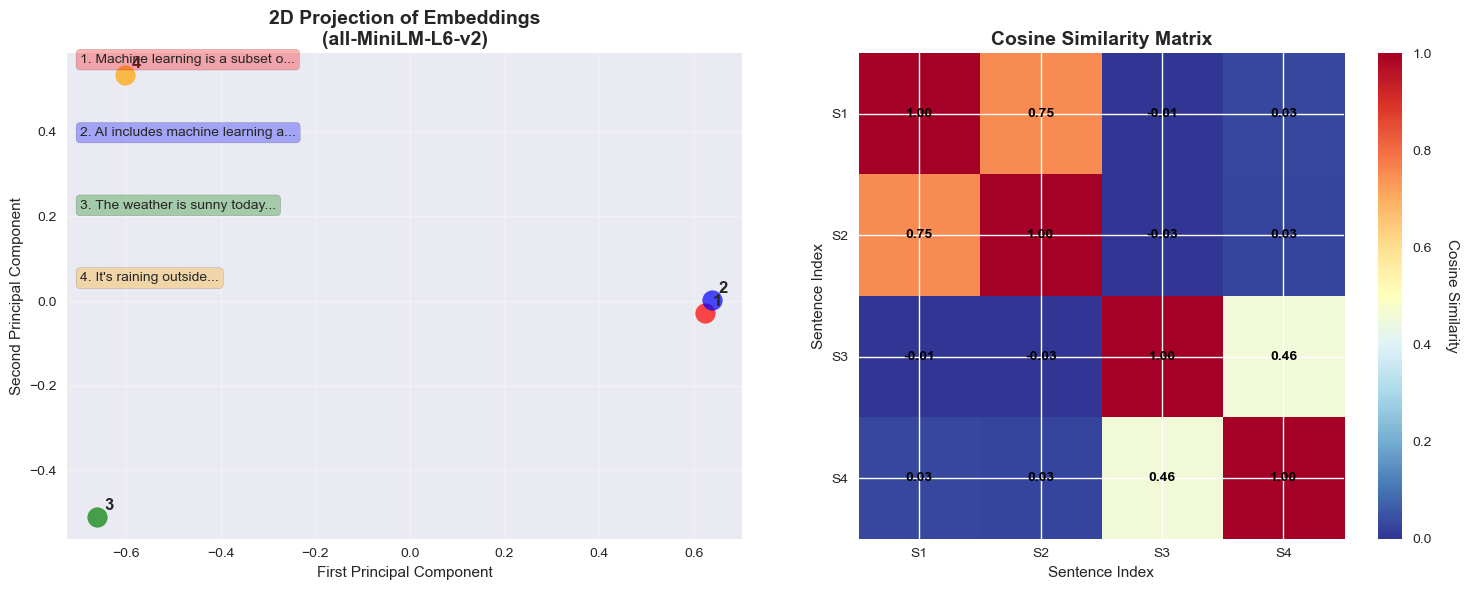


Interpretation:
• Points closer together in the left plot are more similar
• Red (S1) and Blue (S2) should be close - they're about ML/AI
• Green (S3) and Orange (S4) should be close - they're about weather
• The heatmap shows similarity scores between all pairs
• Higher values (closer to 1) = more similar

 Actual Distances in 2D space:
S1 ↔ S2: Distance=0.033, Similarity=0.752
S1 ↔ S3: Distance=1.373, Similarity=-0.009
S1 ↔ S4: Distance=1.349, Similarity=0.031
S2 ↔ S3: Distance=1.396, Similarity=-0.031
S2 ↔ S4: Distance=1.349, Similarity=0.026
S3 ↔ S4: Distance=1.044, Similarity=0.455

Educational Summary

What we learned about embedding models:

1. **Model Types**:
   - Sentence Transformers: Best for RAG (what we use)
   - Word Embeddings: For individual words
   - Contextual Embeddings: For context-aware understanding

2. **Popular Models**:
   - all-MiniLM-L6-v2: Small, fast, good for learning
   - all-mpnet-base-v2: Balanced quality and speed
   - BAAI/bge-base-en-v1.5: Excelle

In [9]:
# Let's visualize the embeddings to better understand how they work
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

print("Visualizing Embeddings")
print("=" * 50)

# Use the first available model for visualization
if results:
    model_name = list(results.keys())[0]
    embeddings = results[model_name]['embeddings']
    similarities = results[model_name]['similarities']
    
    print(f"Visualizing {model_name} embeddings...")
    
    # Reduce dimensions to 2D for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: 2D scatter plot of embeddings
    colors = ['red', 'blue', 'green', 'orange']
    for i, (x, y) in enumerate(embeddings_2d):
        ax1.scatter(x, y, c=colors[i], s=200, alpha=0.7)
        ax1.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')
    
    ax1.set_title(f'2D Projection of Embeddings\n({model_name})', fontsize=14, fontweight='bold')
    ax1.set_xlabel('First Principal Component')
    ax1.set_ylabel('Second Principal Component')
    ax1.grid(True, alpha=0.3)
    
    # Add sentence labels
    for i, sentence in enumerate(test_sentences):
        ax1.text(0.02, 0.98 - i*0.15, f'{i+1}. {sentence[:30]}...', 
                transform=ax1.transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[i], alpha=0.3))
    
    # Plot 2: Similarity heatmap
    im = ax2.imshow(similarities, cmap='RdYlBu_r', vmin=0, vmax=1)
    ax2.set_title('Cosine Similarity Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Sentence Index')
    ax2.set_ylabel('Sentence Index')
    
    # Add similarity values to the heatmap
    for i in range(len(test_sentences)):
        for j in range(len(test_sentences)):
            text = ax2.text(j, i, f'{similarities[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    # Set tick labels
    ax2.set_xticks(range(len(test_sentences)))
    ax2.set_yticks(range(len(test_sentences)))
    ax2.set_xticklabels([f'S{i+1}' for i in range(len(test_sentences))])
    ax2.set_yticklabels([f'S{i+1}' for i in range(len(test_sentences))])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Cosine Similarity', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print(f"\nInterpretation:")
    print(f"• Points closer together in the left plot are more similar")
    print(f"• Red (S1) and Blue (S2) should be close - they're about ML/AI")
    print(f"• Green (S3) and Orange (S4) should be close - they're about weather")
    print(f"• The heatmap shows similarity scores between all pairs")
    print(f"• Higher values (closer to 1) = more similar")
    
    # Show the actual distances
    print(f"\n Actual Distances in 2D space:")
    for i in range(len(test_sentences)):
        for j in range(i+1, len(test_sentences)):
            dist = np.linalg.norm(embeddings_2d[i] - embeddings_2d[j])
            sim = similarities[i][j]
            print(f"S{i+1} ↔ S{j+1}: Distance={dist:.3f}, Similarity={sim:.3f}")

else:
    print("No model results available for visualization")

print("\n" + "="*50)
print("Educational Summary")
print("="*50)
print("""
What we learned about embedding models:

1. **Model Types**:
   - Sentence Transformers: Best for RAG (what we use)
   - Word Embeddings: For individual words
   - Contextual Embeddings: For context-aware understanding

2. **Popular Models**:
   - all-MiniLM-L6-v2: Small, fast, good for learning
   - all-mpnet-base-v2: Balanced quality and speed
   - BAAI/bge-base-en-v1.5: Excellent for production RAG
   - OpenAI's text-embedding-3-large: Best quality, but expensive

3. **Big Company Choices**:
   - OpenAI: Uses their own API models
   - Meta/Facebook: Often uses sentence-transformers
   - Google: Universal Sentence Encoder
   - Microsoft: Azure OpenAI or custom models

4. **Cosine Similarity Formula**:
   cos(θ) = (A · B) / (||A|| × ||B||)
   
5. **Why Cosine Similarity**:
   - Scale invariant (ignores vector length)
   - Range from -1 to 1 (intuitive)
   - Fast to compute
   - Measures angle between vectors

6. **Choosing a Model**:
   - Learning: all-MiniLM-L6-v2 (small, fast)
   - Production: BAAI/bge-base-en-v1.5 (good quality)
   - Enterprise: OpenAI API (best quality, but costs money)
""")


## Step 2: Visualizing Embeddings

Let's visualize these embeddings to see how similar sentences cluster together. This will help you understand how the system "sees" text relationships.


Reducing dimensions for visualization...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


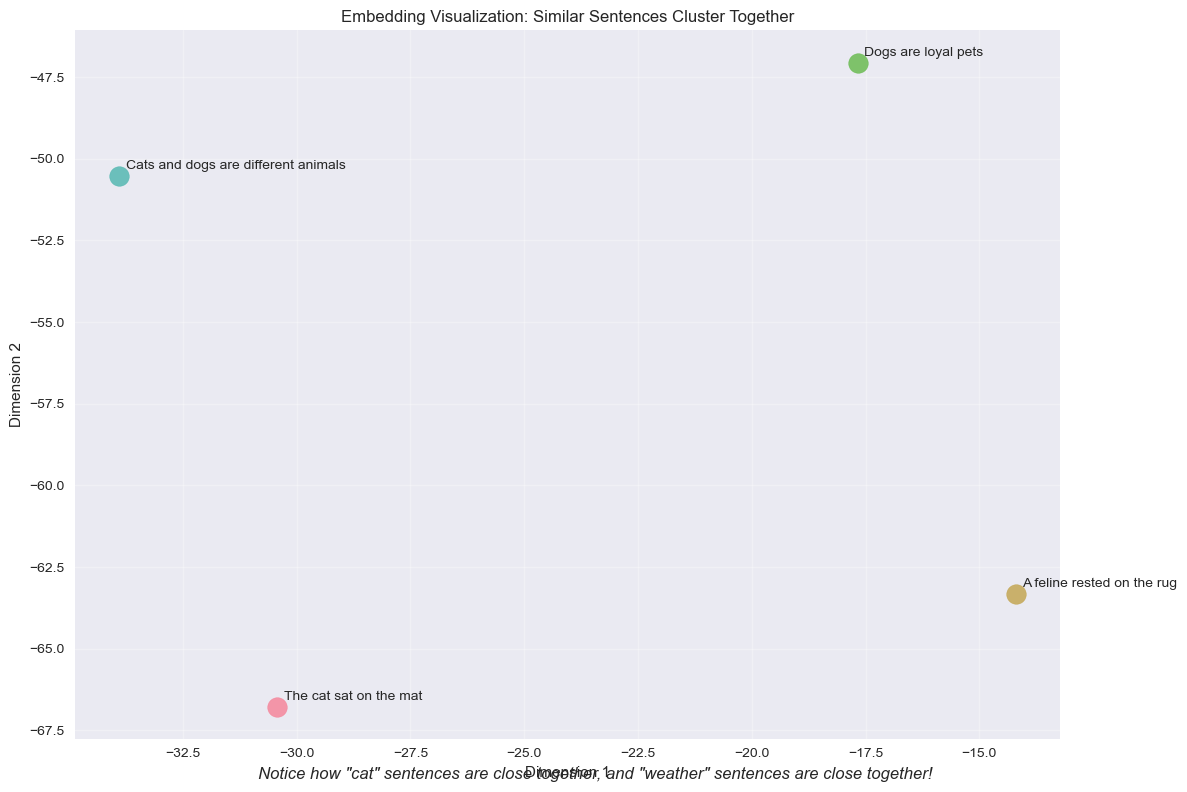

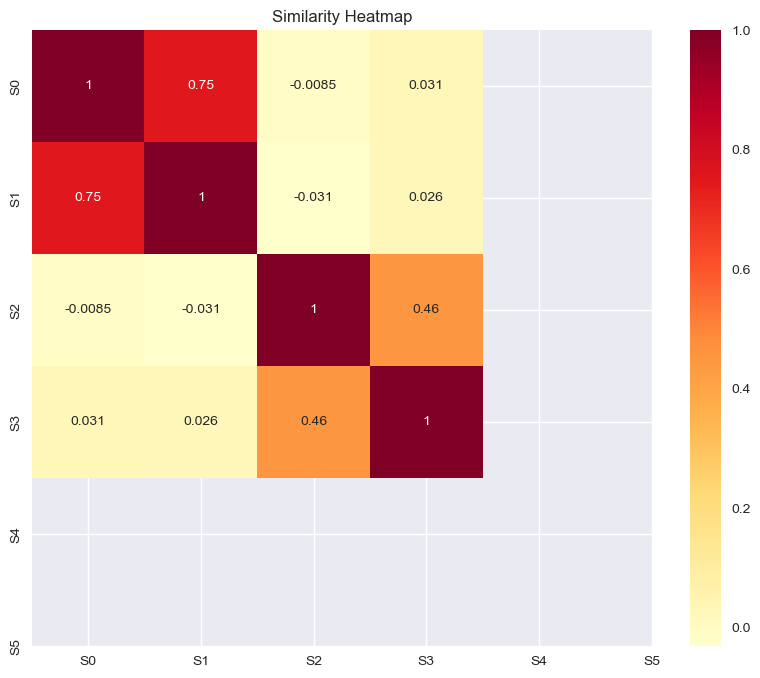


Key Insights:
1. Sentences about cats are more similar to each other than to weather sentences
2. The embedding model understands semantic similarity, not just word overlap
3. This is how RAG systems find relevant documents - by similarity in embedding space!


In [10]:
# Visualize embeddings using dimensionality reduction
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions from 384 to 2 for visualization
print("Reducing dimensions for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity = min(3, len(sentences)-1) if len(sentences) > 3 else 1)
embeddings_2d = tsne.fit_transform(embeddings)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each sentence as a point
for i in range(len(embeddings_2d)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], s=200, alpha=0.7)
    plt.annotate(sentences[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.title('Embedding Visualization: Similar Sentences Cluster Together')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)

# Add some insight
plt.figtext(0.5, 0.02, 
           'Notice how "cat" sentences are close together, and "weather" sentences are close together!', 
           ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.show()

# Let's also create a heatmap of similarities
plt.figure(figsize=(10, 8))
sns.heatmap(similarities, annot=True, cmap='YlOrRd', 
           xticklabels=[f"S{i}" for i in range(len(sentences))],
           yticklabels=[f"S{i}" for i in range(len(sentences))])
plt.title('Similarity Heatmap')
plt.show()

print("\nKey Insights:")
print("1. Sentences about cats are more similar to each other than to weather sentences")
print("2. The embedding model understands semantic similarity, not just word overlap")
print("3. This is how RAG systems find relevant documents - by similarity in embedding space!")


## Step 3: Building a Simple Retrieval System

Now let's build a mini retrieval system to see how this works in practice. We'll create a small "knowledge base" and see how we can find relevant information.


In [11]:
# Let's create a simple knowledge base
knowledge_base = [
    "Cats are small, typically furry, carnivorous mammals. They are often kept as house pets.",
    "Dogs are domesticated mammals that have been selectively bred over thousands of years.",
    "The weather forecast predicts rain for tomorrow with temperatures around 15 degrees Celsius.",
    "Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.",
    "Python is a high-level programming language known for its simplicity and readability.",
    "The solar system consists of eight planets orbiting around the sun.",
    "Cats communicate through various vocalizations including meowing, purring, and hissing.",
    "Dogs are known for their loyalty and are often called 'man's best friend'.",
    "Deep learning uses neural networks with multiple layers to process complex data patterns.",
    "Jupiter is the largest planet in our solar system and has a Great Red Spot."
]

print("Our Knowledge Base:")
for i, fact in enumerate(knowledge_base):
    print(f"{i+1}. {fact}")

# Create embeddings for our knowledge base
print("\nCreating embeddings for knowledge base...")
kb_embeddings = model.encode(knowledge_base)

print(f"Knowledge base embeddings shape: {kb_embeddings.shape}")

# Function to find most relevant documents
def find_relevant_docs(query, knowledge_base, kb_embeddings, model, top_k=3):
    """
    Find the most relevant documents for a given query.
    """
    # Encode the query
    query_embedding = model.encode([query])
    
    # Calculate similarities
    similarities = cosine_similarity(query_embedding, kb_embeddings)[0]
    
    # Get top-k most similar documents
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    results = []
    for i, idx in enumerate(top_indices):
        results.append({
            'rank': i + 1,
            'similarity': similarities[idx],
            'document': knowledge_base[idx]
        })
    
    return results

# Test our retrieval system
test_queries = [
    "Tell me about cats",
    "What is machine learning?",
    "Information about planets",
    "Dog behavior and characteristics"
]

print("\n" + "="*60)
print("TESTING OUR RETRIEVAL SYSTEM")
print("="*60)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 40)
    
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model)
    
    for result in results:
        print(f"Rank {result['rank']} (Similarity: {result['similarity']:.3f}): {result['document']}")
    
    print()


Our Knowledge Base:
1. Cats are small, typically furry, carnivorous mammals. They are often kept as house pets.
2. Dogs are domesticated mammals that have been selectively bred over thousands of years.
3. The weather forecast predicts rain for tomorrow with temperatures around 15 degrees Celsius.
4. Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.
5. Python is a high-level programming language known for its simplicity and readability.
6. The solar system consists of eight planets orbiting around the sun.
7. Cats communicate through various vocalizations including meowing, purring, and hissing.
8. Dogs are known for their loyalty and are often called 'man's best friend'.
9. Deep learning uses neural networks with multiple layers to process complex data patterns.
10. Jupiter is the largest planet in our solar system and has a Great Red Spot.

Creating embeddings for knowledge base...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Knowledge base embeddings shape: (10, 384)

TESTING OUR RETRIEVAL SYSTEM

Query: 'Tell me about cats'
----------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Rank 1 (Similarity: 0.618): Cats are small, typically furry, carnivorous mammals. They are often kept as house pets.
Rank 2 (Similarity: 0.527): Cats communicate through various vocalizations including meowing, purring, and hissing.
Rank 3 (Similarity: 0.354): Dogs are domesticated mammals that have been selectively bred over thousands of years.


Query: 'What is machine learning?'
----------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Rank 1 (Similarity: 0.832): Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.
Rank 2 (Similarity: 0.445): Deep learning uses neural networks with multiple layers to process complex data patterns.
Rank 3 (Similarity: 0.242): Python is a high-level programming language known for its simplicity and readability.


Query: 'Information about planets'
----------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Rank 1 (Similarity: 0.603): The solar system consists of eight planets orbiting around the sun.
Rank 2 (Similarity: 0.516): Jupiter is the largest planet in our solar system and has a Great Red Spot.
Rank 3 (Similarity: 0.228): Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data.


Query: 'Dog behavior and characteristics'
----------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Rank 1 (Similarity: 0.503): Dogs are known for their loyalty and are often called 'man's best friend'.
Rank 2 (Similarity: 0.443): Dogs are domesticated mammals that have been selectively bred over thousands of years.
Rank 3 (Similarity: 0.372): Cats communicate through various vocalizations including meowing, purring, and hissing.



## Step 4: Interactive Query Testing

Let's make this interactive! You can test your own queries and see how well our simple retrieval system works.


In [12]:
# Interactive query testing
def interactive_search():
    """
    Interactive function to test queries against our knowledge base.
    """
    print("Interactive Knowledge Base Search")
    print("="*50)
    print("Enter your questions about cats, dogs, weather, programming, or planets!")
    print("Type 'quit' to exit.")
    print()
    
    while True:
        try:
            query = input("Enter your question: ").strip()
            
            if query.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            
            if not query:
                print("Please enter a question.")
                continue
            
            print(f"\nSearching for: '{query}'")
            print("-" * 40)
            
            results = find_relevant_docs(query, knowledge_base, kb_embeddings, model)
            
            if results:
                for result in results:
                    print(f" Rank {result['rank']} (Similarity: {result['similarity']:.3f})")
                    print(f"   {result['document']}")
                    print()
            else:
                print("No results found.")
            
            print("-" * 40)
            
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break
        except Exception as e:
            print(f"Error: {e}")

# Uncomment the line below to run interactive search
# interactive_search()

# For notebook demonstration, let's show a few more examples
demo_queries = [
    "How do cats communicate?",
    "What programming language is simple?",
    "Which planet is the largest?",
    "Tell me about artificial intelligence"
]

print("Demo: Testing more queries")
print("="*30)

for query in demo_queries:
    print(f"\nQuery: '{query}'")
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model)
    
    for result in results[:2]:  # Show top 2 results
        print(f"  • {result['document']} (Score: {result['similarity']:.3f})")
    
    print()

print("Try running 'interactive_search()' to test your own queries!")


Demo: Testing more queries

Query: 'How do cats communicate?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  • Cats communicate through various vocalizations including meowing, purring, and hissing. (Score: 0.784)
  • Cats are small, typically furry, carnivorous mammals. They are often kept as house pets. (Score: 0.445)


Query: 'What programming language is simple?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  • Python is a high-level programming language known for its simplicity and readability. (Score: 0.637)
  • Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data. (Score: 0.193)


Query: 'Which planet is the largest?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  • Jupiter is the largest planet in our solar system and has a Great Red Spot. (Score: 0.644)
  • The solar system consists of eight planets orbiting around the sun. (Score: 0.485)


Query: 'Tell me about artificial intelligence'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  • Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data. (Score: 0.580)
  • Deep learning uses neural networks with multiple layers to process complex data patterns. (Score: 0.418)

Try running 'interactive_search()' to test your own queries!


## Step 5: Understanding RAG Challenges

Now that we've built a simple retrieval system, let's explore some of the challenges and limitations we'll face when building a real RAG system.


In [ ]:
# Let's explore some RAG challenges with examples

print("RAG System Challenges and Solutions")
print("="*50)

# Challenge 1: Ambiguous queries
print("\n1. AMBIGUOUS QUERIES")
print("-" * 20)

ambiguous_queries = [
    "What is Python?",  # Could be programming language or snake
]

for query in ambiguous_queries:
    print(f"\nQuery: '{query}'")
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model, top_k=2)
    for result in results:
        print(f"  • {result['document']} (Score: {result['similarity']:.3f})")

print("\n Challenge: Without context, the system might retrieve irrelevant information")
print(" Solution: Better query understanding, context from conversation history")

# Challenge 2: Chunking problems
print("\n\n2. CHUNKING CHALLENGES")
print("-" * 25)

# Let's create a longer document and see how chunking affects retrieval
long_document = """
Cats are fascinating animals with a rich history of domestication. 
They were first domesticated in ancient Egypt around 4,000 years ago.
Cats are obligate carnivores, meaning they must eat meat to survive.
They have excellent night vision and can see in light levels six times lower than humans.
Cats communicate through various methods including vocalizations, body language, and scent marking.
The domestic cat is a member of the Felidae family, which includes lions, tigers, and other wild cats.
Cats are known for their independent nature, but they can form strong bonds with their human companions.
They spend a significant portion of their day sleeping, typically 12-16 hours.
Cats have retractable claws that help them climb and hunt effectively.
The average lifespan of a domestic cat is 13-17 years, though some live much longer.
"""

# Split into chunks (simulating chunking)
chunks = [
    "Cats are fascinating animals with a rich history of domestication. They were first domesticated in ancient Egypt around 4,000 years ago.",
    "Cats are obligate carnivores, meaning they must eat meat to survive. They have excellent night vision and can see in light levels six times lower than humans.",
    "Cats communicate through various methods including vocalizations, body language, and scent marking. The domestic cat is a member of the Felidae family, which includes lions, tigers, and other wild cats.",
    "Cats are known for their independent nature, but they can form strong bonds with their human companions. They spend a significant portion of their day sleeping, typically 12-16 hours.",
    "Cats have retractable claws that help them climb and hunt effectively. The average lifespan of a domestic cat is 13-17 years, though some live much longer."
]

print("Original document split into chunks:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk[:60]}...")

# Test retrieval with chunked content
chunk_embeddings = model.encode(chunks)
test_query = "How long do cats sleep?"

print(f"\nQuery: '{test_query}'")
results = find_relevant_docs(test_query, chunks, chunk_embeddings, model, top_k=2)

for result in results:
    print(f"  • {result['document']} (Score: {result['similarity']:.3f})")

print("\n Challenge: Information might be split across chunks")
print(" Solution: Overlapping chunks, better chunking strategies, re-ranking")

# Challenge 3: Similarity threshold
print("\n\n3. SIMILARITY THRESHOLDS")
print("-" * 25)

test_queries = [
    "What is machine learning?",
    "Tell me about neural networks",
    "How does artificial intelligence work?",
    "What is the weather like?"  # This should have low similarity to our knowledge base
]

for query in test_queries:
    results = find_relevant_docs(query, knowledge_base, kb_embeddings, model, top_k=1)
    best_match = results[0]
    
    relevance = " Relevant" if best_match['similarity'] > 0.3 else " Not Relevant"
    print(f"'{query}' -> Best match: {best_match['similarity']:.3f} {relevance}")

print("\n Challenge: Setting appropriate similarity thresholds")
print(" Solution: Experiment with thresholds, use multiple retrieval strategies")

# Challenge 4: Hallucination prevention
print("\n\n4. HALLUCINATION PREVENTION")
print("-" * 30)

# Simulate what might happen if we don't have relevant information
irrelevant_query = "What is the population of Mars?"
results = find_relevant_docs(irrelevant_query, knowledge_base, kb_embeddings, model, top_k=3)

print(f"Query: '{irrelevant_query}'")
print("Retrieved documents:")
for result in results:
    print(f"  • {result['document']} (Score: {result['similarity']:.3f})")

print("\n Challenge: LLM might generate answers even when no relevant info exists")
print(" Solution: Check retrieval quality, use confidence thresholds, provide 'no relevant info' responses")

print("\n" + "="*60)
print("These challenges show why RAG systems need careful design!")
print("In the next notebooks, we'll learn how to address each of these issues.")


 RAG System Challenges and Solutions

1. AMBIGUOUS QUERIES
--------------------

Query: 'What is Python?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  • Python is a high-level programming language known for its simplicity and readability. (Score: 0.837)
  • Machine learning is a subset of artificial intelligence that focuses on algorithms that can learn from data. (Score: 0.240)

 Challenge: Without context, the system might retrieve irrelevant information
 Solution: Better query understanding, context from conversation history


2. CHUNKING CHALLENGES
-------------------------
Original document split into chunks:
Chunk 1: Cats are fascinating animals with a rich history of domestic...
Chunk 2: Cats are obligate carnivores, meaning they must eat meat to ...
Chunk 3: Cats communicate through various methods including vocalizat...
Chunk 4: Cats are known for their independent nature, but they can fo...
Chunk 5: Cats have retractable claws that help them climb and hunt ef...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 'How long do cats sleep?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  • Cats are known for their independent nature, but they can form strong bonds with their human companions. They spend a significant portion of their day sleeping, typically 12-16 hours. (Score: 0.782)
  • Cats have retractable claws that help them climb and hunt effectively. The average lifespan of a domestic cat is 13-17 years, though some live much longer. (Score: 0.549)

 Challenge: Information might be split across chunks
 Solution: Overlapping chunks, better chunking strategies, re-ranking


3. SIMILARITY THRESHOLDS
-------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'What is machine learning?' -> Best match: 0.832  Relevant


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'Tell me about neural networks' -> Best match: 0.622  Relevant


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'How does artificial intelligence work?' -> Best match: 0.553  Relevant


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'What is the weather like?' -> Best match: 0.493  Relevant

 Challenge: Setting appropriate similarity thresholds
 Solution: Experiment with thresholds, use multiple retrieval strategies


4. HALLUCINATION PREVENTION
------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query: 'What is the population of Mars?'
Retrieved documents:
  • Jupiter is the largest planet in our solar system and has a Great Red Spot. (Score: 0.349)
  • The solar system consists of eight planets orbiting around the sun. (Score: 0.333)
  • Dogs are domesticated mammals that have been selectively bred over thousands of years. (Score: 0.117)

 Challenge: LLM might generate answers even when no relevant info exists
 Solution: Check retrieval quality, use confidence thresholds, provide 'no relevant info' responses

These challenges show why RAG systems need careful design!
In the next notebooks, we'll learn how to address each of these issues.


## Summary: What We've Learned

You've now built and tested a basic retrieval system. Here's what we've accomplished:

### Key Concepts Covered:
1. **Embeddings**: Converting text to numerical vectors that capture semantic meaning
2. **Similarity Search**: Finding relevant documents using cosine similarity
3. **Retrieval Pipeline**: Query → Embedding → Similarity → Ranking
4. **Real Challenges**: Ambiguous queries, chunking, thresholds, hallucination

### What You Can Do Now:
- Understand how text embeddings work
- Build a simple retrieval system
- Test queries against a knowledge base
- Identify common RAG challenges
- Visualize how embeddings represent text relationships

### Next Steps:
In the upcoming notebooks, we'll tackle:
1. **Data Collection** - Getting real Wikipedia and ArXiv data
2. **Text Preprocessing** - Cleaning and chunking strategies
3. **Advanced Retrieval** - Better embedding models and search techniques
4. **Generation** - Connecting LLMs to create complete answers
5. **Evaluation** - Measuring how well our system works
